In [18]:
#Tianyu Lu
#Hw1_question1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error
import random

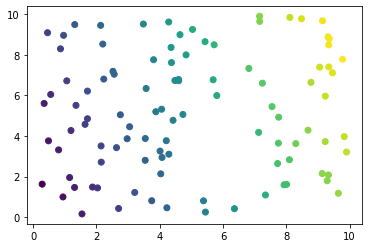

In [3]:
df = pd.read_csv('regression.csv')
x=df.values[:, 0:2]
y=df.values[:,2]
plt.scatter(x[:, 0], x[:, 1],c=y)
plt.show() 

In [8]:
# divide x, y into k list of same size
def getSplitData(x, y, k):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    pList = np.array_split(np.array(arr), k)
    xlist, ylist = [], []
    for fold in pList:
        xlist.append(x[fold])
        ylist.append(y[fold])
    return xlist, ylist

In [9]:
# randomly draw n samples from x, y
def drawSample(x, y, n):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    p1, p2 = arr[:n], arr[n:]
    return x[p1], x[p2], y[p1], y[p2]

In [29]:
# return model trained on x, y;
# and training error
def crossValidation(x, y):
    #split data for cross-validation
    xlist, ylist = getSplitData(x, y, 5)
    trainErr = []
    for i in range(5):
        model = LinearRegression()
#        model = SVR()
        xtest, ytest = xlist[i], ylist[i]
        xtrain = np.concatenate((xlist[:i] + xlist[i+1:]))
        ytrain = np.concatenate((ylist[:i] + ylist[i+1:]))
        model.fit(xtrain, ytrain)
        trainErr.append(mean_squared_error(ytest, model.predict(xtest)))
        model = LinearRegression()
#     model = SVR()
    model.fit(x, y)
    return model, np.mean(trainErr)

In [26]:
# Linear regression model 
# return trainig and test error with cross validation
def randomSample(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 10) # observed and unobserved data
    trainError, testError = [], []
    while len(xObs) < 51:
        # train model + calculate loss
        model, train = crossValidation(xObs, yObs) 
        trainError.append(train)
        testError.append(mean_squared_error(yUnob, model.predict(xUnob)))
        # update sample
        xNew, xUnob, yNew, yUnob = drawSample(xUnob, yUnob, 1)
        xObs = np.concatenate((xObs, xNew))
        yObs = np.concatenate((yObs, yNew))
    return trainError, testError

In [37]:
# train model with random sampling for 10 simulation
obs, unobs = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train, test = randomSample(x, y)
    obs.append(train)
    unobs.append(test)
    
# calculate mean and std for 10 simulation
obsMean = [np.mean(i) for i in np.transpose(np.array(obs))]
obsStd = [np.std(i) for i in np.transpose(np.array(obs))]
unobsMean = [np.mean(i) for i in np.transpose(np.array(unobs))]
unobsStd = [np.std(i) for i in np.transpose(np.array(unobs))]
print(obsMean[0], obsStd[0])

0
1
2
3
4
5
6
7
8
9
0.028971185848302113 0.014722344944351347


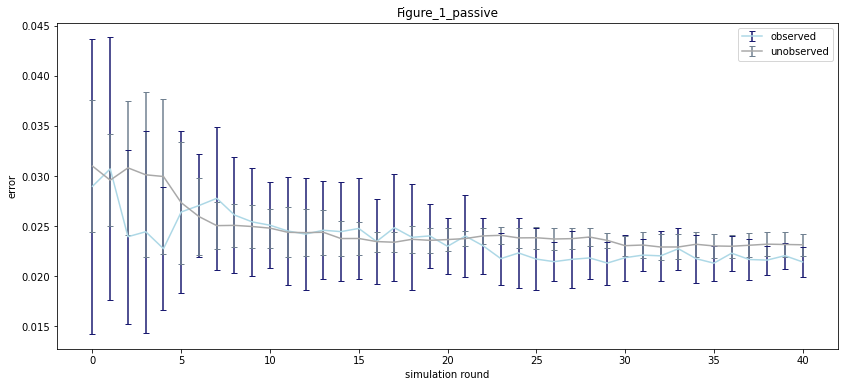

In [39]:
# plot passive learning
# adjusted to exclude first 5 rounds
xaxis = np.arange(len(obsMean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, obsMean, yerr = obsStd,  label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis, unobsMean, yerr = unobsStd, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("error")
plt.title("Figure_1_passive")
plt.legend()
plt.show()

In [11]:
def uncertainSample(model, xtrain, ytrain, xtest, ytest):
    n = len(xtrain)
    sxx1 = sum(xtrain[:, 0])**2-sum(xtrain[:,0])**2/n # feature x1
    sxx2 = sum(xtrain[:, 1])**2-sum(xtrain[:,1])**2/n #feature x2
    s = mean_squared_error(ytrain, model.predict(xtrain))*n/(n-2)
    # calculate variance in all ytest predictions
    var = [s**2*( 1/n + (x[0]-np.mean(xtrain[:,0]))**2/sxx1 \
                 + (x[1]-np.mean(xtrain[:,1]))**2/sxx2) for x in xtest]
    # selects the greatest variance/uncertainty
    p = np.argmax(var) 
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

In [12]:
# train with uncertain sampling
def uncertainTrain(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 10)
    trainError, testError = [], []
    while len(xObs) < 51:
        model, train = crossValidation(xObs, yObs) 
        trainError.append(train)
        testError.append(mean_squared_error(yUnob, model.predict(xUnob)))
        # update sample
        xNew, yNew, xUnob, yUnob = uncertainSample(model,xObs, yObs, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainError, testError

In [36]:
# active learning
obsAccuracy2, unobsAccuracy2 = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train2, test2 = uncertainTrain(x, y)
    obsAccuracy2.append(train2)
    unobsAccuracy2.append(test2)

# calculate metrics
obsMean2 = [np.mean(i) for i in np.transpose(np.array(obsAccuracy2))]
obsStd2 = [np.std(i) for i in np.transpose(np.array(obsAccuracy2))]
unobsMean2 = [np.mean(i) for i in np.transpose(np.array(unobsAccuracy2))]
unobsStd2 = [np.std(i) for i in np.transpose(np.array(unobsAccuracy2))]
print(obsMean[0], obsStd[0])

0
1
2
3
4
5
6
7
8
9
0.028971185848302113 0.014722344944351347


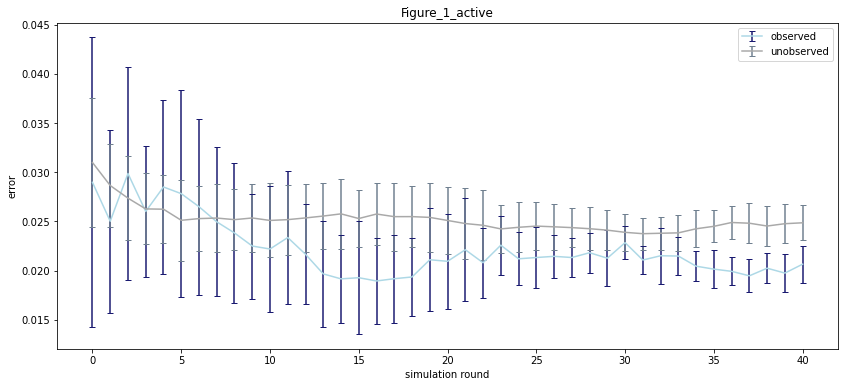

In [38]:
# plot active learning

xaxis = np.arange(len(obsMean2))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, obsMean2, yerr = obsStd2,  label = 'observed', color = 'lightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis, unobsMean2, yerr = unobsStd2, label = 'unobserved', color = 'darkgrey', ecolor='slategrey',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("error")
plt.title("Figure_1_active")
plt.legend()
plt.show()